In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
    
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path

import matplotlib.dates as mdates

import altair as alt
from altair import datum

from scipy.stats import linregress

from wordcloud import WordCloud, STOPWORDS
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()


In [2]:
def review_data_import_clean(product_name, verified_purchase = True):
    df_review = pd.read_csv('data/{}.csv'.format(product_name))
    if verified_purchase:
        df_review = df_review[df_review['verified_purchase'] == 1]
    df_review['review_date_key'] = pd.to_datetime(df_review['review_date'])
    df_review_weekly = df_review.groupby(pd.Grouper(key='review_date_key', freq='W-SUN', label='left', closed='left'))['review_rating']\
                        .agg(['mean', 'count'])\
                        .reset_index()
    df_review_weekly.rename(columns={'mean':'average_rating', 'count':'review_count'}, inplace=True)
    
    return df_review_weekly
def google_data_import_clean(product_name):
    df_gg = pd.read_excel('data/Google Trend.xlsx', sheet_name = product_name)
    df_gg['week_key'] = pd.to_datetime(df_gg['Week'])
    
    df_gg.rename(columns = {df_gg.columns[1]:'trend_index'}, inplace = True)
    df_gg_filter = df_gg[df_gg['trend_index'].cumsum() > 0]
    
    return df_gg_filter

def data_import_clean(product_name, price, verified_purchase = 1):
    
    df_review_clean = review_data_import_clean(product_name, verified_purchase)
    df_gg_clean = google_data_import_clean(product_name)
    
    df = df_review_clean.merge(df_gg_clean, left_on = 'review_date_key', right_on='week_key', how='right')
    df['product_name'] = product_name
    df['price'] = price
    df = df.sort_values('week_key').reset_index().drop('index', axis=1)
    
    return df
def calculate_correlation_review_count(df):
    corr_lst = [(i, df['review_count'].corr(df['trend_index'].shift(i))) for i in range(len(df)//2)]
    df_corr = pd.DataFrame(corr_lst, columns=['lag', 'corr'])
    df_corr['product_name'] = df['product_name'][0]
    df_corr['price'] = df['price'][0]
    return df_corr



In [3]:
product_list = ['AirPods Pro', 'Elite 75t', 'Free', 'Galaxy Buds Plus', 'NC700', 'Soundcore Liberty 2 Pro', 'Soundcore Liberty Air 2', 'Soundcore Life Q20', 'WF-1000XM3']
price_list = [249.0, 179.0, 49.0, 149.0, 399.0, 149.0, 100.0, 59.0, 198.0]

df_corr_review_count = pd.DataFrame(columns=['lag', 'corr', 'product_name', 'price'])

for product, price in zip(*[product_list, price_list]):
    df = data_import_clean(product, price, True)
    df_corr_review_count = pd.concat([df_corr_review_count, calculate_correlation_review_count(df)])
    
df_corr_review_count['segment'] = pd.cut(df_corr_review_count['price'], bins=[0,100,150,200,1000], labels=['Below 100', '100 to 150', '150 to 200', 'Above 200'], right=False)

In [4]:
circle = alt.Chart(df_corr_review_count).mark_circle(
    size = 50
).transform_window(
        sort=[alt.SortField("corr", order="descending")], 
        rank="rank(corr)",
        groupby=['segment','product_name']
).transform_filter(
    alt.datum.rank == 1
).encode(
        x=alt.X("lag:O"), 
        y=alt.Y("corr:Q"),
        color=alt.Color('product_name:N', 
                        title='Product Name', 
                        legend=None)
)

text = alt.Chart(df_corr_review_count).mark_text(
    dy=-10, 
    dx=-15,
    color="red"
).transform_window(
        sort=[alt.SortField("corr", order="descending")], 
        rank="rank(corr)",
        groupby=['segment','product_name']
).transform_filter(
    alt.datum.rank == 1
).encode(
        x=alt.X("lag:O"), 
        y=alt.Y("corr:Q"),
        text=alt.Text("product_name:N"),
)

(circle + text).facet(
    column=alt.Column('segment',
                      sort=['Below 100', '100 to 150', '150 to 200', 'Above 200']
                     )
).properties(
    title='Best Correlation Found for Each Product in Different Price Segments',
).resolve_scale(
    color='independent'
)

alt.FacetChart(...)

In [5]:
def visualize_corr(product_name):
    df = data_import_clean(product_name, 100)
    df_corr = calculate_correlation_review_count(df)
    max_lag = df_corr.iloc[df_corr['corr'].argmax(), 0]
    df['Shifted Google Trend Index'] = df['trend_index'].shift(max_lag)
    df.dropna(subset=['review_count', 'Shifted Google Trend Index'], how='any', inplace=True)
    df['Normalized Amazon Review Count'] = (df['review_count']/df['review_count'].max()*100).round()

    corr_chart = alt.Chart(df).mark_line().transform_fold(
        fold=['Normalized Amazon Review Count', 'Shifted Google Trend Index'], 
        as_=['variable', 'value']
    ).encode(
        x=alt.X('week_key', title=''),
        y=alt.Y('value:Q'),
        color=alt.Color('variable:N', title='', legend=alt.Legend(orient='bottom-right')),
    ).configure_axis(
        grid=False
    ).properties(
        title=[product_name, 
               'Trend of Normalized Amazon Review Count and Google Trend Index (Shifted {} Weeks)'.format(max_lag)]
    )
    
    return corr_chart

In [6]:
visualize_corr('Soundcore Liberty Air 2') 

alt.Chart(...)

In [7]:
visualize_corr('WF-1000XM3')

alt.Chart(...)

In [8]:
visualize_corr('Elite 75t')

alt.Chart(...)

In [9]:
visualize_corr('NC700')

alt.Chart(...)

In [10]:
visualize_corr('AirPods Pro')

alt.Chart(...)

In [11]:
def calculat_weekly_average(verified_purchase=True):
    df = pd.DataFrame(columns=['review_date_key', 'average_rating', 'review_count', 'product_name', 'price'])
    for product, price in zip(*[product_list, price_list]):
        df_new = review_data_import_clean(product, verified_purchase)
        df_new['product_name'] = product
        df_new['price'] = price
        df = pd.concat([df, df_new])
    
    df['review_count'] = df['review_count'].astype(int) # pandas assigns review_count column to object type by default
    
    df_agg = df.groupby(['product_name', 'price']).agg({'average_rating':'mean', 'review_count':'mean'}).reset_index()
    df_agg['review_count_log'] = np.log(df_agg['review_count']) 
    return df_agg
def visualize_regression(df):
    
    coef = linregress(df['review_count_log'], df['average_rating'])
    
    scatter = alt.Chart(df).mark_circle(color='lightgrey').encode(
                            x = alt.X('review_count_log', 
                                      scale={"domain":[2.5,5]}, 
                                      title='Weekly Review Count (Log Scale)'),
                            y = alt.Y('average_rating', 
                                      scale={"domain":[3,5]}, 
                                      title='Average Rating')
                        )
    regression = scatter.transform_regression('review_count_log',
                                              'average_rating',
                                              method="linear"
                        ).mark_line(color='black')
    labels = scatter.mark_text(
                            dy=-10, 
                            dx=-20,
                            size=10
                        ).encode(                
                            text=alt.Text("product_name:N")
                        )
    
    combined = (scatter+regression+labels).properties(title=['Regression Between Weekly Review Count and Average Rating ', 
                                                             'R-Squared: {:.3f}'.format(coef[2]**2)])
    
    return combined



In [12]:
df_review_weekly = calculat_weekly_average()
visualize_regression(df_review_weekly)

alt.LayerChart(...)

In [13]:
   

import numpy as np



def Normalize(array):
    return array / np.linalg.norm(array, ord=1)
    
def GetMergedAmazonDataFrames():
    files_to_use = [r'data\AirPods Pro.csv', r'data\Elite 75t.csv',r'data\Free.csv',
                   r'data\Galaxy Buds Plus.csv',r'data\NC700.csv',
                   r'data\Soundcore Liberty 2 Pro.csv',r'data\Soundcore Liberty Air 2.csv',r'data\Soundcore Life Q20.csv',
                   r'data\WF-1000XM3.csv']
    
    amzn_df = pd.read_csv(files_to_use[0],  parse_dates=False)
    for file in files_to_use[1:]:
        df = pd.read_csv(file,  parse_dates=False)
        amzn_df = pd.concat([amzn_df,df],sort=False)
        
    amzn_df['review_date'] = pd.to_datetime(amzn_df['review_date'], format='%Y-%m-%d')
    amzn_df = amzn_df[['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']]
    return amzn_df

def GetAmazonTextReviewsDf():
    ### This function is used to prepare 
    #   the data frame to word and text analysis.. ####
    amzn_df = GetMergedAmazonDataFrames()
    columns = ['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']
    
    amzn_df=amzn_df[columns]
    return amzn_df
#     amzn_df['totalReviews'] =
 
    
amzn_df = GetMergedAmazonDataFrames()



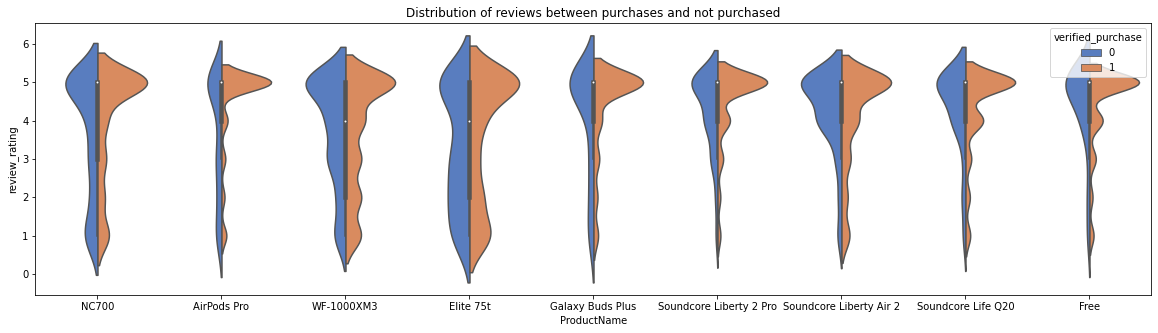

In [14]:
plt.figure(figsize=(20,5))

product_list = [ 'NC700','AirPods Pro','WF-1000XM3', 'Elite 75t',  'Galaxy Buds Plus','Soundcore Liberty 2 Pro', 'Soundcore Liberty Air 2', 'Soundcore Life Q20', 'Free']
price_list = [ 399.0,     249.0,        198.0,            179.0,           149.0, 149.0,    100.0, 59.0, 49.0]

sns_plot = sns.violinplot(x="ProductName", y="review_rating", hue="verified_purchase",
                    data=amzn_df, palette="muted", split=True\
                    , order=product_list
                    ).set_title('Distribution of reviews between purchases and not purchased')


fig = sns_plot.get_figure()

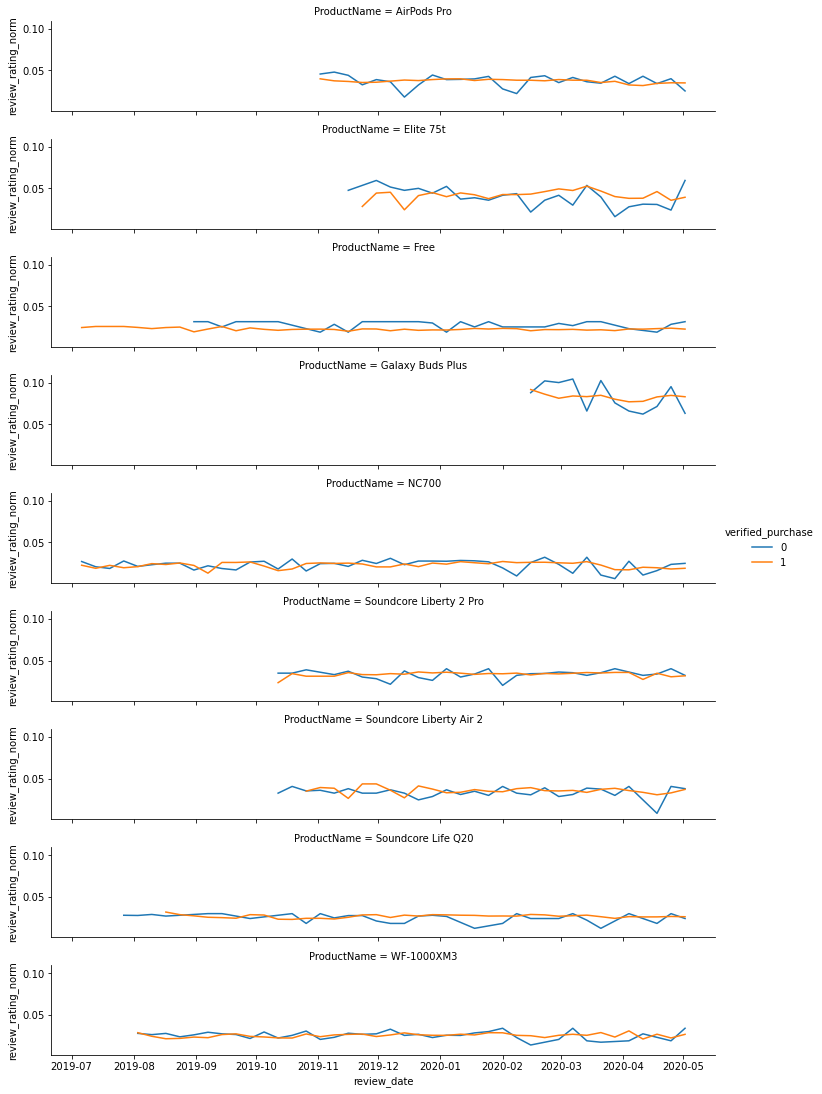

In [15]:
def GetAmazonNumericalReviewsDf():
    amzn_df = GetMergedAmazonDataFrames()
    columns = ['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date']
    
    amzn_df=amzn_df[columns]
    # split into two data sets for purchased and not purchased.
    amzn_purchased = amzn_df.where(amzn_df['verified_purchase']== 1).dropna()
    amzn_notPurchased = amzn_df.where(amzn_df['verified_purchase']== 0).dropna()
    
    tempdf = None
    for product in amzn_purchased['ProductName'].unique():
        df = amzn_purchased.where(amzn_purchased['ProductName'] == product).dropna()
        
        manufacturer = df['Manufacturer'].unique()[0]
        df= df[['review_rating','review_date']]
        
        dfCount = df
        df = df.set_index('review_date').resample('W-SAT').mean().reset_index()#.agg(['mean','count']).reset_index()
#         df['review_rating'] = df['review_rating'].fillna(0)
        df['review_rating_norm'] = Normalize(df['review_rating'].fillna(df['review_rating'].mean()))
        df['ProductName'] = df['review_rating'].apply(lambda x: product)
        df['Manufacturer'] = df['review_rating'].apply(lambda x: manufacturer)
        df['verified_purchase'] = df['review_rating'].apply(lambda x: '1')
        df['count'] = dfCount[['review_rating','review_date']].set_index('review_date').resample('W-SAT').count().reset_index()['review_rating']
#         print(df.head())
        if tempdf is None:
            tempdf = df
        else:
            tempdf = pd.concat([tempdf, df])
            
    
    for product in amzn_notPurchased['ProductName'].unique():
        df = amzn_notPurchased.where(amzn_notPurchased['ProductName'] == product).dropna()
        
        manufacturer = df['Manufacturer'].unique()[0]
        df= df[['review_rating','review_date']]
        
        dfCount = df
        
        
        df = df.set_index('review_date').resample('W-SAT').mean().reset_index()#.agg(['mean','count']).reset_index()
#         df['review_rating'] = df['review_rating'].fillna(0)
        df['review_rating_norm'] = Normalize(df['review_rating'].fillna(df['review_rating'].mean()))
        df['ProductName'] = df['review_rating'].apply(lambda x: product)
        df['Manufacturer'] = df['review_rating'].apply(lambda x: manufacturer)
        df['verified_purchase'] = df['review_rating'].apply(lambda x: '0')
        df['count'] = dfCount[['review_rating','review_date']].set_index('review_date').resample('W-SAT').count().reset_index()['review_rating']
        
#         print(df.head())
        if tempdf is None:
            tempdf = df
        else:
            tempdf = pd.concat([tempdf, df])
            
    return tempdf



df = GetAmazonNumericalReviewsDf().dropna()

ordered_days = df.ProductName
g = sns.FacetGrid(df, row="ProductName", hue="verified_purchase", height=1.7, aspect=6,)
g.map(sns.lineplot, "review_date", "review_rating_norm").add_legend()

In [16]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

def TokenizeText(text):
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    return tokens


def CleanText(text):
    text=str(text)
    text= text.lower().replace("wouldn\'t","would not").replace('canceling','cancelling')
    return text
def helperGetWordsWithTokenType(text, t):   
    tokens = TokenizeText(text)          
    return [x[0] for x in nltk.pos_tag(tokens) if x[1] in t]
    
def GetAdjectivesFromText(text):
    text = CleanText(text)
    return helperGetWordsWithTokenType(text,['JJ'])

def GetWordPairs(text):
    text = CleanText(text)
    tokens = TokenizeText(text)
   
    STOPWORDS = ['of' ,'the', 'i', 'on', 'and', 'm', 'it' ,'s', 've', 'if' ,'to', 'don' ,'t' ,'are' ,'they'\
                 ,'not', 'but','them' ,'do' ,'then' ,'you' ,'me' \
                 ,'these' ,'a' ,'is' ,'for', 'can', 'you' ,'this' ,'my', 'we' ,'can', 'have', 'than', 'with']  
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    tokens = [ ps.stem(elem) for elem in tokens if elem not in STOPWORDS]
    
    if len(tokens)< 2:
        return []
    
    pairs = []
    for i in range(0,len(tokens)-1,1):
        firstWord = tokens[i]
        secondWord = tokens[i+1]
        pairs.append(set([firstWord,secondWord]))
    return pairs

from collections import defaultdict
def count_frequency(word_list):
    """ Function input: list object contains strings of individual words.
        Function output: defaultdict() object containing {word, frequency} pairs. """

    freq_counts = defaultdict(int)
    
    for word in word_list:
        freq_counts[word] += 1

    return freq_counts


def AddAdjectiveNounsVerbsToDF(df, textColumn):
    df = df.copy()
    df['text_adjectives'] =df[textColumn].apply(lambda x: GetAdjectivesFromText(str(x).lower()))
    df['text_adjectives'] = df['text_adjectives'].apply(lambda row: set([  x for x in row if(len(x) >1)]) )

    # create word pairs.
    df['text_pairs'] = df[textColumn].apply(lambda row: GetWordPairs(row))
    return df

def GetDataframeOfWords(pandasdf, textColumn):
    pandasdf['words']=pandasdf[textColumn]
    wordArray = pandasdf[pandasdf['words'].map(lambda d: len(d)) > 0]['words'].values
    words = []
    for wordlist in wordArray:
        words.extend(wordlist)
    wordDictionary = count_frequency(words)
    
    df = pd.DataFrame.from_dict(wordDictionary, orient='index',
                       columns=['count']).reset_index()
    df = df.rename(columns={"index": "word"})
    df = df.sort_values(by=['count'], ascending=False)
    
    totalWords = df['count'].sum()
    df['usage'] = df['count']/totalWords
    return df

amzn_df = GetAmazonTextReviewsDf()
amzn_df = AddAdjectiveNounsVerbsToDF(amzn_df,'review_text')



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AngryGamers\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\AngryGamers\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [17]:
def SingleWords_df(df):
    data = df.copy()
    data = data[['verified_purchase','review_date', 'text_adjectives']]
    # highAdjectivesRanking['text_adjectives'] = highAdjectivesRanking['text_adjectives'].apply(lambda x: repr(x))
    data["tempPairs"] = data["text_adjectives"]
    data = data['text_adjectives'].apply(lambda x: pd.Series(list(x)))\
        .merge(data, right_index = True, left_index = True) \
        .drop(["tempPairs"], axis = 1)\
        .drop(["text_adjectives"], axis = 1)\
        .melt(id_vars = ['review_date', 'verified_purchase'], value_name = "words") \
        .drop("variable", axis = 1).dropna()
    
    
    # count should be a ratio of the current elem/total sets. NOTE: can't really count them here...value too small.
    totalReview= len(df['verified_purchase'])
    data['count'] = data['verified_purchase'].apply(lambda x: 1/totalReview)
    
    return data

df = amzn_df.copy()
lowAdjectivesRanking = df.where(df['review_rating'] < 2).dropna()
lowAdjectivesRanking = SingleWords_df(lowAdjectivesRanking)

highAdjectivesRanking = df.where(df['review_rating'] > 4).dropna()
highAdjectivesRanking = SingleWords_df(highAdjectivesRanking)
    
adjCount_temp = highAdjectivesRanking[['words']]
adjCount_temp2 = lowAdjectivesRanking[['words']]

intersection = adjCount_temp.merge(adjCount_temp2, left_on='words', right_on='words', how='inner')


lowwordsDump = lowAdjectivesRanking[~lowAdjectivesRanking['words']\
                                    .isin(intersection['words'].unique())]\
                                    .groupby('words').sum()\
                                    .sort_values(by='count',ascending=False).reset_index()
highwordsDump = highAdjectivesRanking[~highAdjectivesRanking['words']\
                                      .isin(intersection['words'].unique())]\
                                      .groupby('words').sum()\
                                      .sort_values(by='count',ascending=False).reset_index()
highwordsDump

c:\users\angrygamers\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,words,verified_purchase,count
0,phenomenal,269.0,0.037319
1,skeptical,175.0,0.024517
2,lightweight,142.0,0.020048
3,affordable,143.0,0.018478
4,snug,124.0,0.017874
...,...,...,...
1949,demanded,1.0,0.000121
1950,decided,1.0,0.000121
1951,db,1.0,0.000121
1952,sportsound,1.0,0.000121


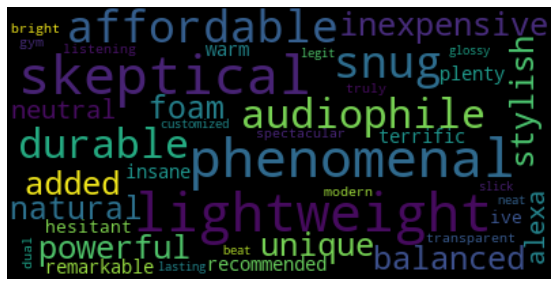

In [18]:
text = highwordsDump[0:40]['words'].apply(lambda x: str(x)).values

text = ' '.join(text)

import os
from os import path
from wordcloud import WordCloud
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
import matplotlib.pyplot as plt

wordcloud = WordCloud(max_font_size=40).generate(text)


plt.figure(figsize=(20,5))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [19]:

def GetHighAndLowRankingUniqueWords(df, wordColumn):
    lowAdjectivesRanking = df.where(df['review_rating'] < 2).dropna()
    lowAdjectivesRanking = SingleWords_df(lowAdjectivesRanking)

    highAdjectivesRanking = df.where(df['review_rating'] > 4).dropna()
    highAdjectivesRanking = SingleWords_df(highAdjectivesRanking)
    
    adjCount_temp = highAdjectivesRanking[[wordColumn,'count']]\
        .groupby([wordColumn])\
        .sum()\
        .sort_values(by='count',ascending=False).reset_index()
    adjCount_temp2 = lowAdjectivesRanking[[wordColumn,'count']]\
        .groupby([wordColumn])\
        .sum()\
        .sort_values(by='count',ascending=False).reset_index()

    intersection = adjCount_temp.merge(adjCount_temp2, left_on=wordColumn, right_on=wordColumn, how='inner')

    top_adj_words_df = highAdjectivesRanking[~highAdjectivesRanking[wordColumn]\
                                             .isin(intersection[wordColumn].unique())].groupby(wordColumn).sum()\
                                             .sort_values(by='count',ascending=False)
    lower_adj_words_df = lowAdjectivesRanking[~lowAdjectivesRanking[wordColumn]\
                                              .isin(intersection[wordColumn].unique())].groupby(wordColumn).sum()\
                                              .sort_values(by='count',ascending=False)

    df = lower_adj_words_df.reset_index().reset_index()[['index',wordColumn]]
    top_adj_words_df=top_adj_words_df.reset_index().reset_index()[['index',wordColumn]]

    onevfiveStarReviewWords_df = df.merge(top_adj_words_df, left_on='index', right_on='index', how='inner')
    onevfiveStarReviewWords_df = onevfiveStarReviewWords_df\
                        .rename(columns={wordColumn+'_x':'oneStarWords', 
                                         wordColumn+'_y':'fiveStarWords','index':'rank'})
    return onevfiveStarReviewWords_df
def GetProductUniqueWords(df):
    products = df['ProductName'].unique()
    
    temp_df = None
    for elem in products:
        p_df = df.where(df['ProductName'] == elem)
        
        p_df = GetHighAndLowRankingUniqueWords(p_df, 'words')
        # now we have a data set of the top and lowest words for a specific product
        # let's rename oneStarWords to the productNameTop,productNameLowest
        p_df = p_df.rename(columns={'oneStarWords':elem+'_worst','fiveStarWords':elem+'_best'})
        
        if temp_df is None:
            temp_df = p_df
        else:
            temp_df = temp_df.merge(p_df, left_on='rank', right_on='rank', how='inner')
        
    return temp_df

productSingleWords = GetProductUniqueWords(amzn_df)

bestColumns = ['AirPods Pro_best', 'Elite 75t_best','Free_best',
       'Galaxy Buds Plus_best', 'NC700_best','Soundcore Liberty 2 Pro_best',
       'Soundcore Liberty Air 2_best','Soundcore Life Q20_best',
       'WF-1000XM3_best']

bestSingleProductWords = productSingleWords[bestColumns]
bestSingleProductWords[:10]

c:\users\angrygamers\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,AirPods Pro_best,Elite 75t_best,Free_best,Galaxy Buds Plus_best,NC700_best,Soundcore Liberty 2 Pro_best,Soundcore Liberty Air 2_best,Soundcore Life Q20_best,WF-1000XM3_best
0,awesome,amazing,little,long,super,different,awesome,little,black
1,incredible,awesome,usb,awesome,outstanding,awesome,excellent,awesome,impressed
2,true,impressive,perfect,clear,large,overall,overall,solid,android
3,top,hearthrough,overall,able,clean,amazing,amazing,expensive,solid
4,pleased,passive,expensive,overall,favorite,fantastic,perfect,impressed,helpful
5,solid,slight,high,previous,crystal,liberty,fantastic,build,minor
6,advertised,light,battery,excellent,pretty,wireless,wireless,battery,strong
7,outstanding,crisp,noise,perfect,rich,small,true,own,superior
8,everyday,intuitive,impressed,battery,alexa,big,pleased,ambient,convenient
9,hear,real,compact,active,phenomenal,incredible,black,incredible,hear


In [20]:

def GetReviewPairsCounts(df):
    data = df.copy()

    data['text_pairs_valid']=data['text_pairs'].apply(lambda x: True if len(x)>0 else False)
    data = data.where(data['text_pairs_valid'] == True).dropna().drop(columns=['text_pairs_valid'])

    data['text_pairs'] = data['text_pairs'].apply(lambda x: [tuple(elem) for elem in x ])
    data= data[['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text','text_pairs']]

    data = data.set_index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']).apply(pd.Series.explode).reset_index()

    totalReview= len(df['verified_purchase'])
    
    return data


fivestarsPairs_df = amzn_df.where(amzn_df['review_rating'] == 5).dropna()

df =GetReviewPairsCounts(fivestarsPairs_df)
print(df.columns)
df['count']=df['text_pairs'].apply(lambda x: 1)

df = df.groupby(['ProductName','Manufacturer','text_pairs']).sum()\
        .reset_index().sort_values(by=['ProductName','count'], ascending=False)


def GetTopProductPairs(df):
    df = GetReviewPairsCounts(df)
    df['count']=df['text_pairs'].apply(lambda x: 1)
    
    highReviews = df.where(df['review_rating'] > 4).dropna()
    lowReviews = df.where(df['review_rating'] < 2).dropna()
    
    products = df['ProductName'].unique()
    
    temp = None
    for product in products:
        temp_df = df.where(df['ProductName'] == product).dropna()
        high = temp_df.where(temp_df['review_rating'] > 4).dropna()[['text_pairs','count']]
        low  = temp_df.where(temp_df['review_rating'] < 2).dropna()[['text_pairs','count']]
        
        intersection = high[['text_pairs']].merge(low, left_on='text_pairs', right_on='text_pairs', how='inner')

        high['text_pairs'].isin(intersection['text_pairs'].unique())
        
        top_adj_words_df = high[~high['text_pairs']\
                                .isin(intersection['text_pairs'].unique())]\
                                .groupby('text_pairs').sum()\
                                .sort_values(by='count',ascending=False).reset_index()
        lower_adj_words_df = low[~low['text_pairs']\
                                 .isin(intersection['text_pairs'].unique())]\
                                 .groupby('text_pairs').sum()\
                                 .sort_values(by='count',ascending=False).reset_index()
        top_adj_words_df = top_adj_words_df.rename(columns={'text_pairs':product+'_best'})\
                            .reset_index().drop(columns=['count'])
        lower_adj_words_df = lower_adj_words_df.rename(columns={'text_pairs':product+'_worst'})\
                            .reset_index().drop(columns=['count'])
        
        tdf = top_adj_words_df.merge(lower_adj_words_df, left_on='index', right_on='index', how='inner')

        if temp is None:
            temp=tdf
        else:
            temp= temp.merge(tdf, left_on='index', right_on='index', how='inner')
        
    return temp

productWordPairs = GetTopProductPairs(amzn_df)[:20]

productBest = productWordPairs[['index', 'AirPods Pro_best','Elite 75t_best',
       'Free_best', 'Galaxy Buds Plus_best',
       'NC700_best',
       'Soundcore Liberty 2 Pro_best', 
       'Soundcore Liberty Air 2_best', 
       'Soundcore Life Q20_best', 
       'WF-1000XM3_best']]

productBest[:10].drop(columns=['index'])

Index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text', 'text_pairs'],
      dtype='object')


,AirPods Pro_best,Elite 75t_best,Free_best,Galaxy Buds Plus_best,NC700_best,Soundcore Liberty 2 Pro_best,Soundcore Liberty Air 2_best,Soundcore Life Q20_best,WF-1000XM3_best
0,"(great, product)","(truli, wireless)","(so, far)","(sound, ambient)","(touch, control)","(in, ear)","(charg, wireless)","(as, good)","(connect, app)"
1,"(great, qualiti)","(so, far)","(c, usb)","(call, qualiti)","(veri, comfort)","(ear, your)","(well, as)","(great, price)","(as, far)"
2,"(great, fit)","(realli, good)","(great, qualiti)","(airpod, pro)","(bose, sound)","(earbud, wireless)","(recommend, highli)","(so, far)","(that, headphon)"
3,"(he, love)","(recommend, highli)","(realli, good)","(so, far)","(block, out)","(in, your)","(airpod, pro)","(last, batteri)","(great, product)"
4,"(earbud, wireless)","(in, app)","(as, good)","(earbud, wireless)","(nois, level)","(veri, good)","(great, product)","(at, price)","(best, earbud)"
5,"(well, worth)","(featur, through)","(recommend, highli)","(great, qualiti)","(veri, well)","(amaz, sound)","(realli, good)","(bass, boost)","(use, easi)"
6,"(sound, amaz)","(high, mid)","(great, product)","(all, day)","(veri, happi)","(charg, case)","(wireless, true)","(nois, good)","(so, good)"
7,"(worth, definit)","(bud, galaxi)","(great, price)","(ear, your)","(veri, nice)","(music, listen)","(better, sound)","(great, product)","(bud, galaxi)"
8,"(worth, everi)","(secur, fit)","(earfun, free)","(music, listen)","(high, end)","(sound, best)","(touch, control)","(veri, nice)","(amaz, sound)"
9,"(from, upgrad)","(great, qualiti)","(last, batteri)","(better, much)","(high, qualiti)","(call, phone)","(airpod, appl)","(set, headphon)","(much, how)"
